# Fundamentos de analítica 2 (clase 2)

## Diego Fernando Agudelo
## Universidad ICESI
## diegoagudelo30@gmail.com

**Integrantes**

*   Andrés Felipe Borrero
*   Yesid Castelblanco Caro
*   Nicolás Colmenares
*   Carlos Alberto Martinez Ramirez




## **1. Carga de paquetes**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error
import math

## **2. Carga de datos**

In [2]:
data = pd.read_excel("/content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [3]:
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=12,freq='MS')

## **3. Entrenamiento de modelos**

In [7]:
h = 6 # Periodo de prediccion

### Tendencia lineal

In [8]:
y = data["Ocupados"]
x = np.linspace(1,data.shape[0],data.shape[0])
X = sm.add_constant(x)
X_train = X[:-h]
y_train = y[:-h]
X_test = X[-h:]
y_test = y[-h:]

lin = sm.OLS(y_train,X_train)
lin_t = lin.fit()

In [9]:
dt = lin_t.get_prediction(X_test).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(y_test.index[-h:],inplace=True)

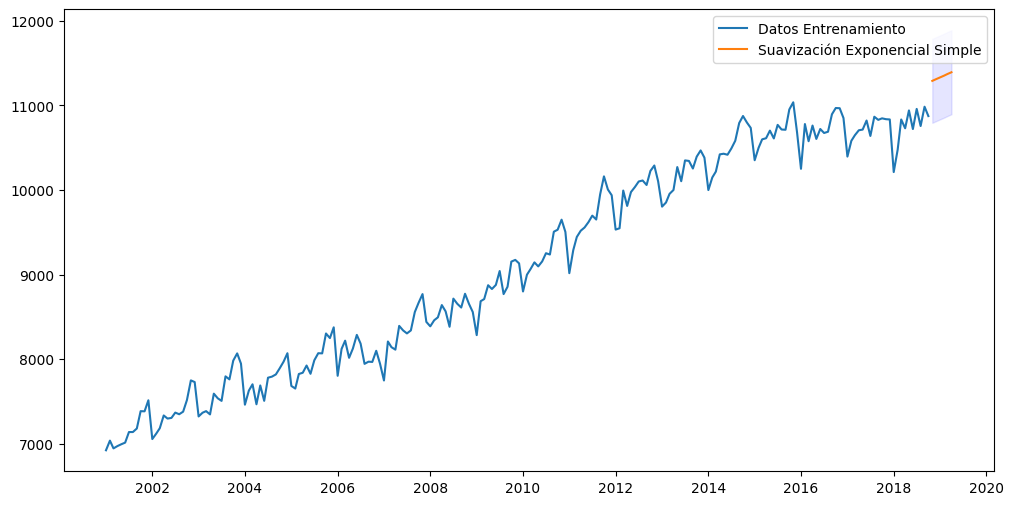

In [10]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y_train.index,y_train,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [11]:
rmse_lin = math.sqrt(mean_squared_error(y_test, y_prd))
print(f"RMSE: {rmse_lin}")

RMSE: 718.651675100181


### Tendencia cuadratica

In [12]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = data["x"]**2
X = sm.add_constant(data[["x","x2"]])
X_train = X[:-h]
y_train = y[:-h]
X_test = X[-h:]
y_test = y[-h:]
pol = sm.OLS(y_train,X_train)
pol_2 = pol.fit()

In [13]:
dt = pol_2.get_prediction(X_test).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(y_test.index,inplace=True)

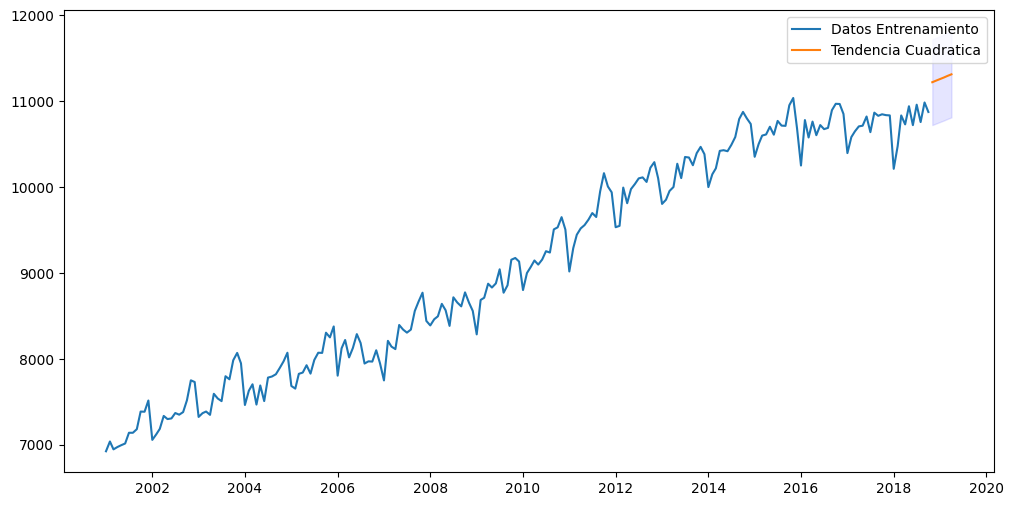

In [14]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y_train.index,y_train,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Tendencia Cuadratica")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [15]:
rmse_pol = math.sqrt(mean_squared_error(y_test, y_prd))
print(f"RMSE: {rmse_pol}")

RMSE: 646.5978131665922


### Estacionalidad

In [18]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index).astype(int)

y = data["Ocupados"]
X = sm.add_constant(month_dummies)

X_train = X[:-h]
y_train = y[:-h]
X_test = X[-h:]
y_test = y[-h:]

sea = sm.OLS(y_train,X_train)
season = sea.fit()

In [19]:
dt = season.get_prediction(X_test).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(y_test.index,inplace=True)

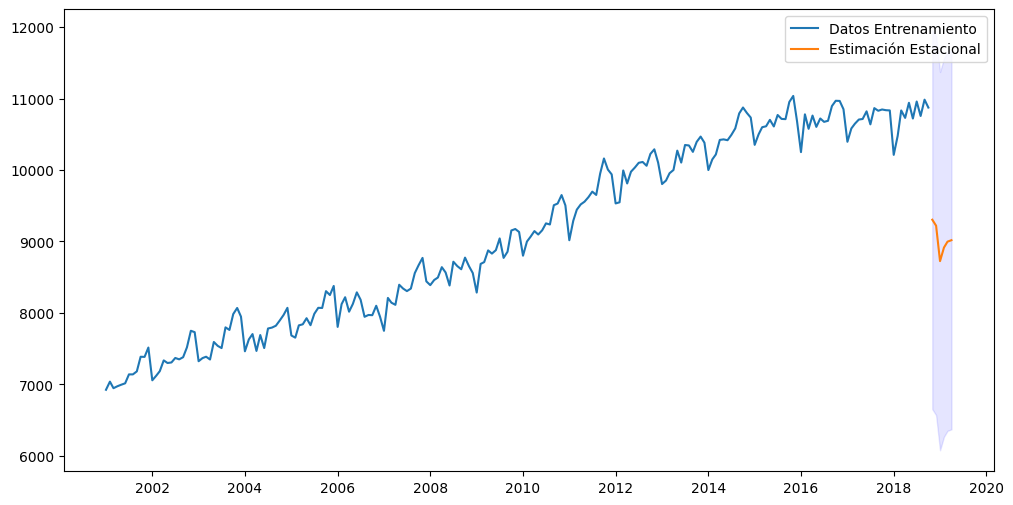

In [20]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y_train.index,y_train,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [22]:
rmse_season = math.sqrt(mean_squared_error(y_test, y_prd))
print(f"RMSE: {rmse_season}")

RMSE: 1619.614226804036


### Tendencia + Estacionalidad

In [23]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = data["x"]**2

month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index).astype(int)
X = sm.add_constant( pd.concat([data[["x","x2"]],month_dummies],axis=1) )

X_train = X[:-h]
y_train = y[:-h]
X_test = X[-h:]
y_test = y[-h:]

season_pol2 = sm.OLS(y_train,X_train)
season_pol_2 = season_pol2.fit()

In [24]:
dt = season_pol_2.get_prediction(X_test).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(y_test.index,inplace=True)

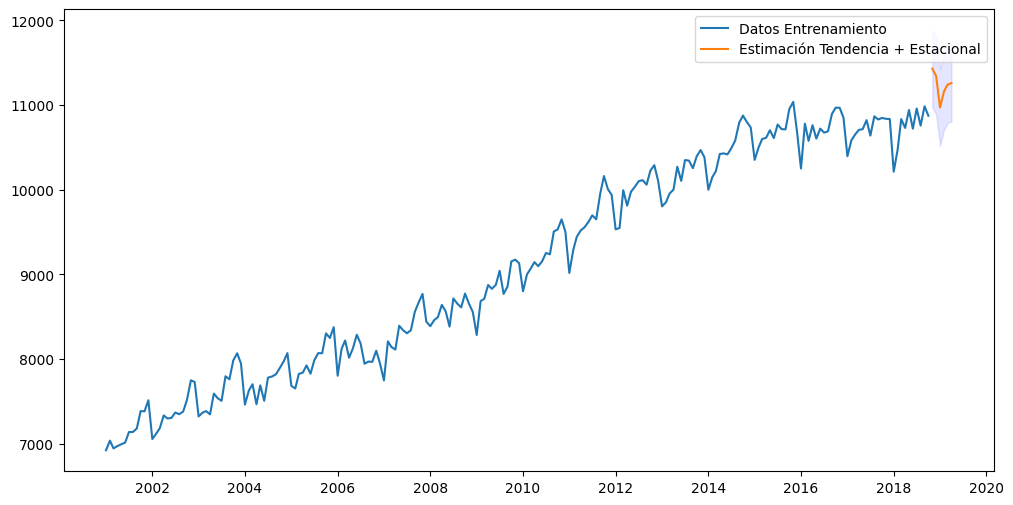

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y_train.index,y_train,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [26]:
rmse_season_pol = math.sqrt(mean_squared_error(y_test, y_prd))
print(f"RMSE: {rmse_season_pol}")

RMSE: 590.479495713149


## **4. Comparación de modelos**

In [28]:
rmse_df = pd.DataFrame({
    'Modelo': ['Tendencia lineal', 'Tendencia cuadratica', 'Estacionalidad', 'Tendecia + Estacionalidad'],
    'RMSE': [rmse_lin, rmse_pol, rmse_season, rmse_season_pol]
})
print(rmse_df)

                      Modelo         RMSE
0           Tendencia lineal   718.651675
1       Tendencia cuadratica   646.597813
2             Estacionalidad  1619.614227
3  Tendecia + Estacionalidad   590.479496


## **5. Generando predicción a 6 meses**

In [29]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = data["x"]**2

month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index).astype(int)
X = sm.add_constant( pd.concat([data[["x","x2"]],month_dummies],axis=1) )

season_pol2 = sm.OLS(y,X)
season_pol_2 = season_pol2.fit()
print(season_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     500.8
Date:                Tue, 17 Dec 2024   Prob (F-statistic):          5.58e-148
Time:                        02:09:35   Log-Likelihood:                -1504.4
No. Observations:                 220   AIC:                             3037.
Df Residuals:                     206   BIC:                             3084.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6514.3526     69.120     94.247      0.0

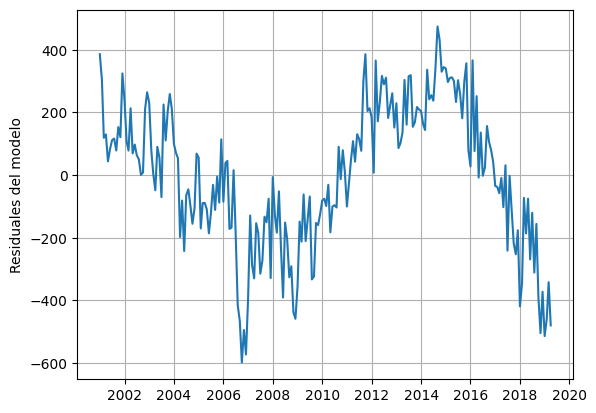

In [30]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_2.resid)
plt.grid()

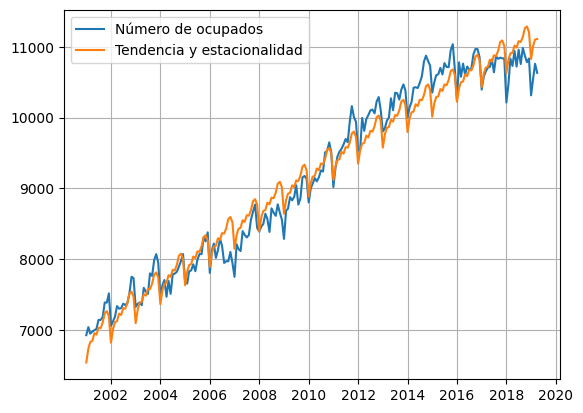

In [31]:
plt.plot(y,label="Número de ocupados")
plt.plot(season_pol_2.fittedvalues,label="Tendencia y estacionalidad")
plt.legend()
plt.grid()
plt.show()

In [32]:
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] )

range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=12,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True).astype(int)[:h]

X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))

In [33]:
dt = season_pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates[:h],inplace=True)
print(preds)

            Point_forecast      lower_95      upper_95
2019-05-01    11211.838909  10730.817019  11692.860800
2019-06-01    11184.654419  10703.336346  11665.972492
2019-07-01    11273.916096  10792.294026  11755.538167
2019-08-01    11261.729940  10779.796071  11743.663808
2019-09-01    11334.200450  10851.946998  11816.453902
2019-10-01    11457.262404  10974.681599  11939.843210


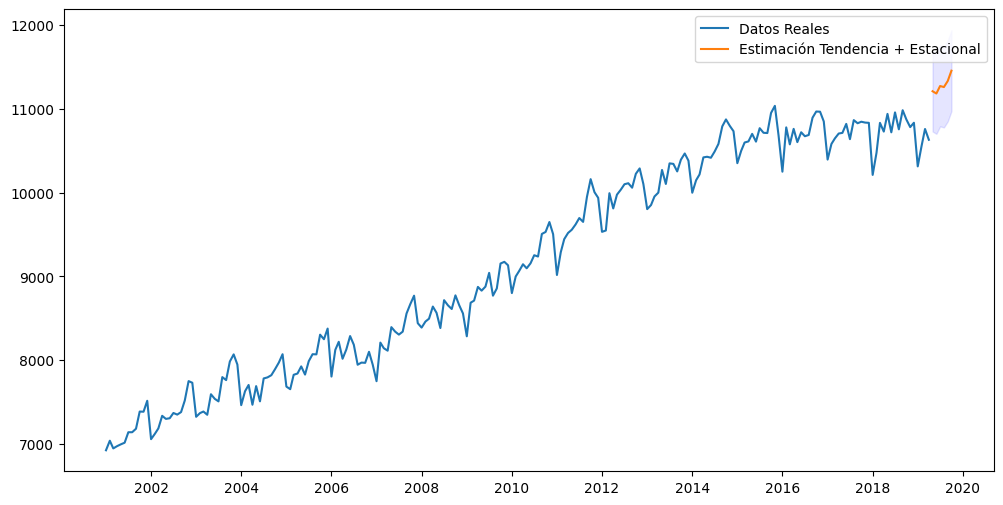

In [34]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Reales")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

## **6. Validación de supuestos**




### Prueba de Autocorrelación en los residuales con las pruebas Box-Pierce y Ljung-Box.

In [35]:
resids = season_pol_2.resid

In [36]:
# Prueba de Box-Pierce
box_pierce = sm.stats.acorr_ljungbox(resids, lags=[10], return_df=True)
print("Prueba de Box-Pierce:")
print(box_pierce)

# Prueba de Ljung-Box
ljung_box = sm.stats.acorr_ljungbox(resids, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box:")
print(ljung_box)

Prueba de Box-Pierce:
        lb_stat      lb_pvalue
10  1027.046693  2.786526e-214

Prueba de Ljung-Box:
        lb_stat      lb_pvalue
10  1027.046693  2.786526e-214


Prueba de **Homoscedasticidad/Heteroscedasticidad** sobre los residuales.

In [38]:
# Prueba de Ljung-Box con los residuales al cuadrado
ljung_box_squared = sm.stats.acorr_ljungbox(resids**2, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box con residuales al cuadrado:")
print(ljung_box)


Prueba de Ljung-Box con residuales al cuadrado:
        lb_stat      lb_pvalue
10  1027.046693  2.786526e-214


Prueba de **Normalidad** sobre los residuales.

In [39]:
# Prueba de Jarque-Bera
jarque_bera = stats.jarque_bera(resids)
print("\nPrueba de Jarque-Bera:")
print(f"Estadístico: {jarque_bera[0]}")
print(f"p-valor: {jarque_bera[1]}")

# Prueba de Shapiro-Wilk
shapiro_wilk = stats.shapiro(resids)
print("\nPrueba de Shapiro-Wilk:")
print(f"Estadístico: {shapiro_wilk[0]}")
print(f"p-valor: {shapiro_wilk[1]}")


Prueba de Jarque-Bera:
Estadístico: 6.165829058877201
p-valor: 0.0458255020530994

Prueba de Shapiro-Wilk:
Estadístico: 0.9818882817041724
p-valor: 0.00638171376262112


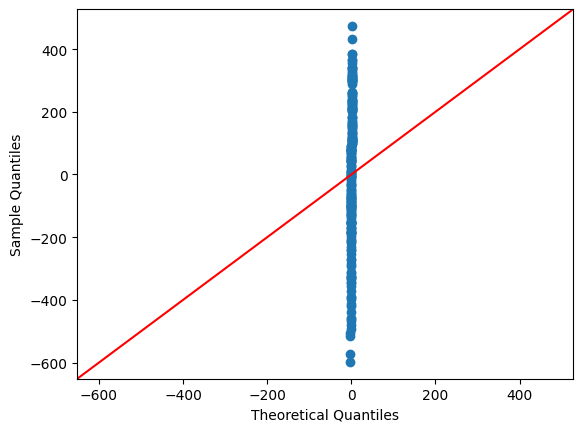

In [41]:
sm.qqplot(resids, line='45')
py.show()